In [1]:
!python -V

Python 3.11.7


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

## Q1: Downloading the Data

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

In [6]:
dfj = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [7]:
dfj.shape

(3066766, 19)

In [10]:
dfj.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.0,0.0,1.0,14.3,2.5,0.0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.0,0.0,1.0,16.9,2.5,0.0


## Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

In [11]:
dfj['duration'] = dfj.tpep_dropoff_datetime - dfj.tpep_pickup_datetime

In [12]:
dfj.duration.head()

0   0 days 00:08:26
1   0 days 00:06:19
2   0 days 00:12:45
3   0 days 00:09:37
4   0 days 00:10:50
Name: duration, dtype: timedelta64[us]

In [13]:
dfj.duration = dfj.duration.apply(lambda td: td.total_seconds() / 60)

In [14]:
dfj.duration.head()

0     8.433333
1     6.316667
2    12.750000
3     9.616667
4    10.833333
Name: duration, dtype: float64

In [17]:
dfj.duration.std()

42.594351241920904

## Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [18]:
len(dfj[(dfj.duration >= 1) & (dfj.duration <= 60)]) / len(dfj.duration)

0.9812202822125979

In [19]:
len(dfj.duration)

3066766

In [20]:
dfj2 = dfj[(dfj.duration >= 1) & (dfj.duration <= 60)]

In [21]:
len(dfj2.duration)

3009173

In [22]:
len(dfj2.duration) / len(dfj.duration)

0.9812202822125979

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. 

We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

In [25]:
dfj2.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [26]:
categorical = ['PULocationID', 'DOLocationID']
#numerical = ['trip_distance']

dfj2[categorical] = dfj2[categorical].astype(str)

/tmp/ipykernel_2667/182261090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfj2[categorical] = dfj2[categorical].astype(str)


In [29]:
dfj2.dtypes[['PULocationID','DOLocationID']]

PULocationID    object
DOLocationID    object
dtype: object

In [30]:
train_dicts = dfj2[categorical].to_dict(orient='records')
#train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [31]:
X_train.shape

(3009173, 515)

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters, where duration is the response variable
- Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [34]:
target = 'duration'
y_train = dfj2[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [35]:
y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.649261961655295

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

In [36]:
dff = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [37]:
dff.shape

(2913955, 19)

In [38]:
dff['duration'] = dff.tpep_dropoff_datetime - dff.tpep_pickup_datetime
dff.duration = dff.duration.apply(lambda td: td.total_seconds() / 60)
dff[categorical] = dff[categorical].astype(str)

In [44]:
dff = dff[(dff.duration >= 1) & (dff.duration <= 60)]

In [45]:
test_dicts = dff[categorical].to_dict(orient='records')

X_test = dv.transform(test_dicts)

In [46]:
y_test = dff[target].values
y_pred2 = lr.predict(X_test)

mean_squared_error(y_test, y_pred2, squared=False)

7.811819038564729

# End of Homework

/tmp/ipykernel_2667/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2667/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level functi

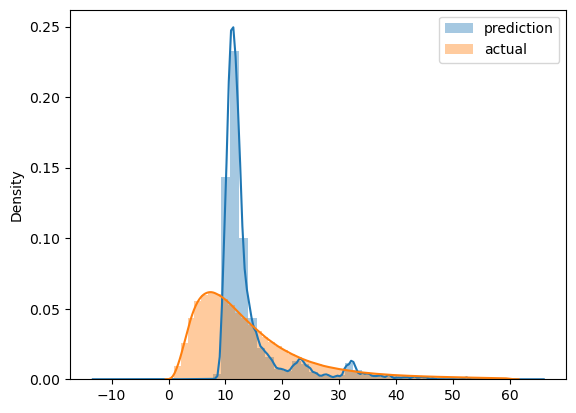

In [47]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

/tmp/ipykernel_2667/1117898716.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred2, label='prediction')
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2667/1117898716.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level funct

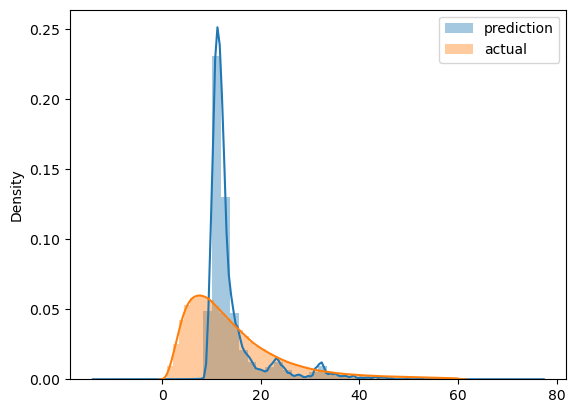

In [48]:
sns.distplot(y_pred2, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()

In [9]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [10]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479513631630414

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728